In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV




In [88]:
data = pd.read_csv('../data/transaction_detail.csv')  # Replace 'your_dataset.csv' with your actual file path

# Drop unnecessary columns
data = data.drop(["Transaction_ID", "Account_Creation_Date"], axis=1)



In [89]:
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_Amount           64 non-null     float64
 1   Transaction_Date             64 non-null     object 
 2   Transaction_Time             64 non-null     object 
 3   User_Account_ID              64 non-null     int64  
 4   Payment_Method               64 non-null     object 
 5   Billing_Location             64 non-null     object 
 6   Shipping_Location            64 non-null     object 
 7   Device_IP_Address            64 non-null     object 
 8   Session_Duration             64 non-null     object 
 9   Frequency_of_Transactions    64 non-null     int64  
 10  Time_Between_Transactions    64 non-null     object 
 11  Unusual_Time_of_Transaction  64 non-null     int64  
 12  Unusual_Transaction_Amounts  64 non-null     int64  
 13  IP_Address_History    

In [90]:
print(data.isnull().sum())


Transaction_Amount             0
Transaction_Date               0
Transaction_Time               0
User_Account_ID                0
Payment_Method                 0
Billing_Location               0
Shipping_Location              0
Device_IP_Address              0
Session_Duration               0
Frequency_of_Transactions      0
Time_Between_Transactions      0
Unusual_Time_of_Transaction    0
Unusual_Transaction_Amounts    0
IP_Address_History             0
Fraud_Label                    0
dtype: int64


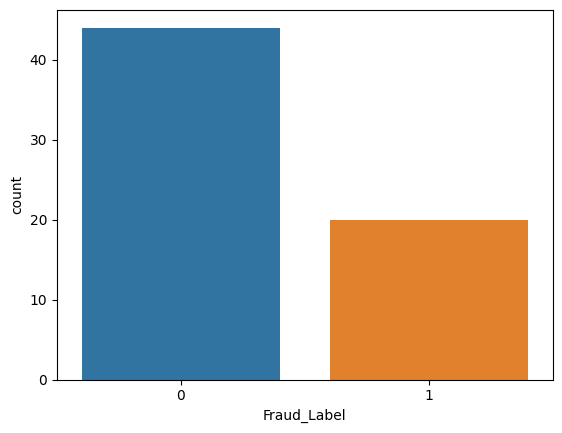

In [91]:
sns.countplot(x='Fraud_Label', data=data)
plt.show()

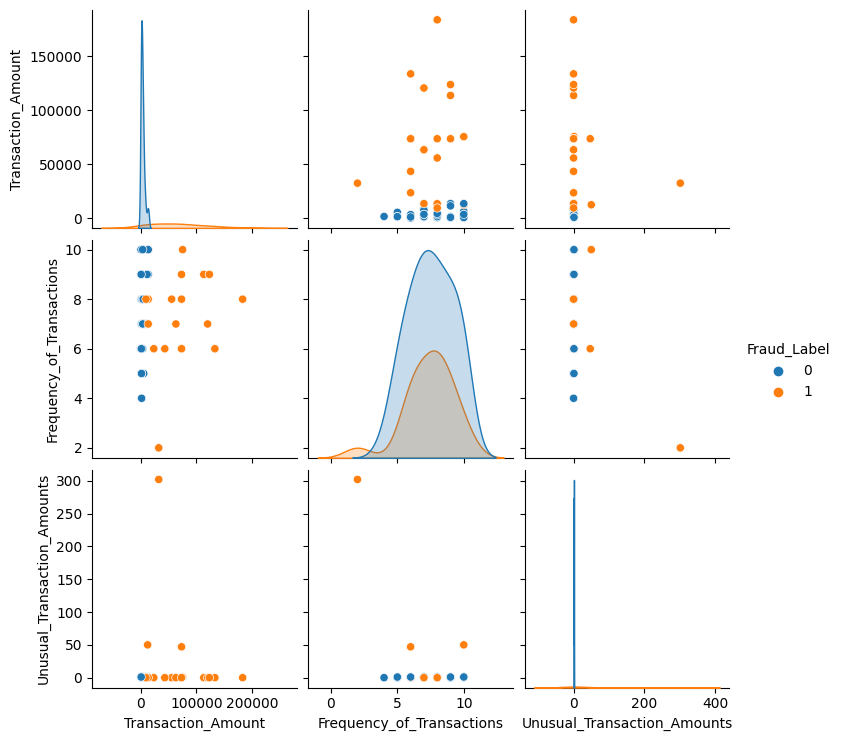

In [92]:
important_columns = ['Transaction_Amount', 'Frequency_of_Transactions', 'Session_Duration', 'Time_Between_Transactions', 'Unusual_Transaction_Amounts']

# Add the target variable for coloring
important_columns.append('Fraud_Label')

# Subset the dataframe with important columns
subset_data = data[important_columns]

# Create a pair plot
sns.pairplot(subset_data, hue='Fraud_Label')
plt.show()

In [93]:
# Convert Transaction_Date to datetime
data["Transaction_Date"] = pd.to_datetime(data["Transaction_Date"])

# Feature Engineering for date and time
data["Day_of_Week"] = data["Transaction_Date"].dt.dayofweek
data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour

# Convert categorical variables into numerical representations using Label Encoding
label_encoder = LabelEncoder()

object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Convert date and time columns to numeric format
data["Transaction_Date"] = data["Transaction_Date"].dt.strftime("%Y%m%d").astype(int)
data["Transaction_Time"] = pd.to_datetime(data["Transaction_Time"]).dt.strftime("%H%M%S").astype(int)



C:\Users\Yash\AppData\Local\Temp\ipykernel_5848\3374887820.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour


In [94]:
# Split the dataset into features (X) and target variable (y)
X = data.drop("Fraud_Label", axis=1)
y = data["Fraud_Label"]


In [95]:
# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [96]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [97]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}


In [98]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)


In [99]:

# Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(xgb_model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'max_depth': 3, 'n_estimators': 50}


In [100]:
#Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy with Best Model: {accuracy_best:.2f}")

Accuracy with Best Model: 1.00


In [101]:
import pickle

# Save the trained model to a file
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [102]:
new_input = {
    'Transaction_Amount': 150.0,
    'Transaction_Date': '2023-05-10',
    'Transaction_Time': '18:30:00',
    'User_Account_ID': 101,
    'Account_Creation_Date': '2022-09-15',
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'Mumbai',
    'Shipping_Location': 'Mumbai',
    'Device_IP_Address': '192.168.1.10',
    'Session_Duration': '600 seconds',
    'Frequency_of_Transactions': 5,
    'Time_Between_Transactions': '120 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.10'
}



AttributeError: 'XGBClassifier' object has no attribute 'pkl'

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier

# Assuming your dataset is stored in a DataFrame called data

# Drop columns that might not contribute significantly to the model

# Split the dataset into features (X) and target variable (y)
X = data.drop("Fraud_Label", axis=1)
y = data["Fraud_Label"]

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a voting classifier
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the ensemble model on the training set
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [109]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_input(input_data):
    encoded_data = input_data.copy()

    # Define encoding mappings if needed
    payment_method_mapping = {'Credit Card': 0, 'UPI': 1, 'Other': 2}
    location_mapping = {'New York': 0, 'Mumbai': 1, 'Chennai': 2, 'Pune': 3, 'Other': 4}

    # Encode Payment_Method
    encoded_data['Payment_Method'] = payment_method_mapping.get(encoded_data['Payment_Method'], -1)

    # Encode Billing_Location and Shipping_Location
    encoded_data['Billing_Location'] = location_mapping.get(encoded_data['Billing_Location'], -1)
    encoded_data['Shipping_Location'] = location_mapping.get(encoded_data['Shipping_Location'], -1)

    # Convert Session_Duration and Time_Between_Transactions to integers
    encoded_data['Session_Duration'] = int(encoded_data['Session_Duration'].split()[0])
    encoded_data['Time_Between_Transactions'] = int(encoded_data['Time_Between_Transactions'].split()[0])

    return encoded_data

def predict_fraud(input_data, ensemble_model):
    # Load label encoders
    label_encoder_payment = LabelEncoder()
    label_encoder_billing = LabelEncoder()
    label_encoder_shipping = LabelEncoder()
    label_encoder_ip = LabelEncoder()

    # Assuming your input_data is a DataFrame with a single row
    input_df = pd.DataFrame([input_data])

    # Encode categorical variables
    input_df['Payment_Method'] = label_encoder_payment.transform(input_df['Payment_Method'])
    input_df['Billing_Location'] = label_encoder_billing.transform(input_df['Billing_Location'])
    input_df['Shipping_Location'] = label_encoder_shipping.transform(input_df['Shipping_Location'])
    input_df['Device_IP_Address'] = label_encoder_ip.transform(input_df['Device_IP_Address'])

    # Make predictions
    predicted_prob = ensemble_model.predict_proba(input_df)[:, 1]

    # Return the predicted probability
    return predicted_prob[0]

# Example usage:
new_input = {
    'Transaction_Amount': 150.0,
    'User_Account_ID': 105,
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'New York',
    'Shipping_Location': 'New York',
    'Device_IP_Address': '192.168.1.20',
    'Session_Duration': '300 seconds',
    'Frequency_of_Transactions': 3,
    'Time_Between_Transactions': '180 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.20'
}

encoded_input = encode_input(new_input)
predicted_probability = predict_fraud(encoded_input, ensemble_model)

print(f"Predicted Probability of Fraud: {predicted_probability:.4f}")


NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [117]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def fit_label_encoders(data):
    label_encoder_payment = LabelEncoder()
    label_encoder_billing = LabelEncoder()
    label_encoder_shipping = LabelEncoder()
    label_encoder_ip = LabelEncoder()

    # Fit label encoders
    label_encoder_payment.fit(data['Payment_Method'])
    label_encoder_billing.fit(data['Billing_Location'])
    label_encoder_shipping.fit(data['Shipping_Location'])
    label_encoder_ip.fit(data['Device_IP_Address'])

    return label_encoder_payment, label_encoder_billing, label_encoder_shipping, label_encoder_ip

def encode_input(input_data, label_encoder_billing, label_encoder_shipping, label_encoder_ip):
    # Ensure the input_data is a DataFrame with a single row
    input_df = pd.DataFrame([input_data])

    # Handle categorical variables with one-hot encoding
    input_df = pd.get_dummies(input_df, columns=['Payment_Method'], drop_first=True)

    # Encode Billing_Location, Shipping_Location, and Device_IP_Address
    input_df['Billing_Location'] = label_encoder_billing.transform(input_df['Billing_Location'])
    input_df['Shipping_Location'] = label_encoder_shipping.transform(input_df['Shipping_Location'])
    input_df['Device_IP_Address'] = label_encoder_ip.transform(input_df['Device_IP_Address'])

    # Convert Session_Duration and Time_Between_Transactions to integers
    input_df['Session_Duration'] = int(input_df['Session_Duration'].split()[0])
    input_df['Time_Between_Transactions'] = int(input_df['Time_Between_Transactions'].split()[0])

    return input_df






def predict_fraud(input_data, ensemble_model, label_encoder_payment, label_encoder_billing, label_encoder_shipping, label_encoder_ip):
    # Assuming your input_data is a DataFrame with a single row
    input_df = pd.DataFrame([input_data])

    # Encode categorical variables
    input_df['Payment_Method'] = label_encoder_payment.transform(input_df['Payment_Method'])
    input_df['Billing_Location'] = label_encoder_billing.transform(input_df['Billing_Location'])
    input_df['Shipping_Location'] = label_encoder_shipping.transform(input_df['Shipping_Location'])
    input_df['Device_IP_Address'] = label_encoder_ip.transform(input_df['Device_IP_Address'])

    # Make predictions
    predicted_prob = ensemble_model.predict_proba(input_df)[:, 1]

    # Return the predicted probability
    return predicted_prob[0]

# Example usage:
label_encoder_payment, label_encoder_billing, label_encoder_shipping, label_encoder_ip = fit_label_encoders(data)

new_input = {
    'Transaction_Amount': 150.0,
    'User_Account_ID': 105,
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'New York',
    'Shipping_Location': 'New York',
    'Device_IP_Address': '192.168.1.20',
    'Session_Duration': '300 seconds',
    'Frequency_of_Transactions': 3,
    'Time_Between_Transactions': '180 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.20'
}

encoded_input = encode_input(new_input, label_encoder_billing, label_encoder_shipping, label_encoder_ip)
predicted_probability = predict_fraud(encoded_input, ensemble_model, label_encoder_payment, label_encoder_billing, label_encoder_shipping, label_encoder_ip)

print(f"Predicted Probability of Fraud: {predicted_probability:.4f}")


ValueError: invalid literal for int() with base 10: 'New York'

In [118]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('../data/transaction_detail.csv')

# Convert Transaction_Date and Transaction_Time to datetime
data["Transaction_Date"] = pd.to_datetime(data["Transaction_Date"])
data["Day_of_Week"] = data["Transaction_Date"].dt.dayofweek
data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour

# Convert categorical variables into numerical representations using Label Encoding
label_encoder = LabelEncoder()

object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Convert date and time columns to numeric format
data["Transaction_Date"] = data["Transaction_Date"].dt.strftime("%Y%m%d").astype(int)
data["Transaction_Time"] = pd.to_datetime(data["Transaction_Time"]).dt.strftime("%H%M%S").astype(int)


C:\Users\Yash\AppData\Local\Temp\ipykernel_5848\558815898.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Assuming your dataset is stored in a DataFrame called data

# Drop unnecessary columns
data = data.drop(["Transaction_ID", "Transaction_Date", "Transaction_Time"], axis=1)

# Split the dataset into features (X) and target variable (y)
X = data.drop("Fraud_Label", axis=1)
y = data["Fraud_Label"]

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [120]:
def predict_fraud_ensemble(input_data):
    # Preprocess input_data
    encoded_input = encode_input(input_data, label_encoder, label_encoder, label_encoder)

    # Make predictions using both models
    rf_pred = rf_model.predict(encoded_input)
    xgb_pred = xgb_model.predict(encoded_input)

    # Combine predictions (for simplicity, using a voting mechanism)
    ensemble_pred = (rf_pred + xgb_pred) // 2

    return ensemble_pred


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('../data/transaction_detail.csv')

# Convert Transaction_Date and Transaction_Time to datetime
data["Transaction_Date"] = pd.to_datetime(data["Transaction_Date"])
data["Day_of_Week"] = data["Transaction_Date"].dt.dayofweek
data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour

# Convert categorical variables into numerical representations using Label Encoding
label_encoder = LabelEncoder()

object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Convert date and time columns to numeric format
data["Transaction_Date"] = data["Transaction_Date"].dt.strftime("%Y%m%d").astype(int)
data["Transaction_Time"] = pd.to_datetime(data["Transaction_Time"]).dt.strftime("%H%M%S").astype(int)

# Drop unnecessary columns
data = data.drop(["Transaction_ID", "Transaction_Date", "Transaction_Time"], axis=1)

# Split the dataset into features (X) and target variable (y)
X = data.drop("Fraud_Label", axis=1)
y = data["Fraud_Label"]

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Now, you can use rf_model to predict whether a new input is fraud or not
new_input = {
    'Transaction_Amount': 1250,
    'User_Account_ID': 101,
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'Mumbai',
    'Shipping_Location': 'Mumbai',
    'Device_IP_Address': '192.168.1.10',
    'Session_Duration': '600 seconds',
    'Frequency_of_Transactions': 5,
    'Time_Between_Transactions': '120 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.10'
}

# Preprocess input_data
encoded_input = label_encoder.transform([new_input[col] for col in X.columns])
prediction = rf_model.predict([encoded_input])

print(f"Fraud Prediction: {prediction}")


C:\Users\Yash\AppData\Local\Temp\ipykernel_9108\2635111785.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



KeyError: 'Account_Creation_Date'

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('../data/transaction_detail.csv')

# Convert Transaction_Date and Transaction_Time to datetime
data["Transaction_Date"] = pd.to_datetime(data["Transaction_Date"])
data["Day_of_Week"] = data["Transaction_Date"].dt.dayofweek
data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour

# Convert categorical variables into numerical representations using Label Encoding
label_encoder = LabelEncoder()

object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Convert date and time columns to numeric format
data["Transaction_Date"] = data["Transaction_Date"].dt.strftime("%Y%m%d").astype(int)
data["Transaction_Time"] = pd.to_datetime(data["Transaction_Time"]).dt.strftime("%H%M%S").astype(int)

# Split the dataset into features (X) and target variable (y)
X = data.drop(["Fraud_Label", "Transaction_ID"], axis=1)  # Include 'Account_Creation_Date' here
y = data["Fraud_Label"]

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Now, you can use rf_model to predict whether a new input is fraud or not
new_input = {
    'Transaction_Amount': 1250,
    'User_Account_ID': 101,
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'Mumbai',
    'Shipping_Location': 'Mumbai',
    'Device_IP_Address': '192.168.1.10',
    'Session_Duration': '600 seconds',
    'Frequency_of_Transactions': 5,
    'Time_Between_Transactions': '120 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.10',
    'Account_Creation_Date': '2022-09-15'
}

# Preprocess input_data
encoded_input = label_encoder.transform([new_input[col] for col in X.columns])
prediction = rf_model.predict([encoded_input])

print(f"Fraud Prediction: {prediction}")


C:\Users\Yash\AppData\Local\Temp\ipykernel_9108\964858106.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



KeyError: 'Transaction_Date'

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('../data/transaction_detail.csv')

# Convert Transaction_Date and Transaction_Time to datetime
data["Transaction_Date"] = pd.to_datetime(data["Transaction_Date"])
data["Day_of_Week"] = data["Transaction_Date"].dt.dayofweek
data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour

# Convert categorical variables into numerical representations using Label Encoding
label_encoder = LabelEncoder()

object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Convert date and time columns to numeric format
data["Transaction_Date"] = data["Transaction_Date"].dt.strftime("%Y%m%d").astype(int)
data["Transaction_Time"] = pd.to_datetime(data["Transaction_Time"]).dt.strftime("%H%M%S").astype(int)

# Split the dataset into features (X) and target variable (y)
X = data.drop(["Fraud_Label", "Transaction_ID"], axis=1)  # Ensure correct column names
y = data["Fraud_Label"]

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Now, you can use rf_model to predict whether a new input is fraud or not
new_input = {
    'Transaction_Amount': 1250,
    'User_Account_ID': 101,
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'Mumbai',
    'Shipping_Location': 'Mumbai',
    'Device_IP_Address': '192.168.1.10',
    'Session_Duration': '600 seconds',
    'Frequency_of_Transactions': 5,
    'Time_Between_Transactions': '120 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.10',
    'Account_Creation_Date': '2022-09-15'
}

# Preprocess input_data
encoded_input = label_encoder.transform([new_input[col] for col in X.columns])
prediction = rf_model.predict([encoded_input])

print(f"Fraud Prediction: {prediction}")


C:\Users\Yash\AppData\Local\Temp\ipykernel_9108\1918622723.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Hour_of_Day"] = pd.to_datetime(data["Transaction_Time"]).dt.hour


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



KeyError: 'Transaction_Date'